<a href="https://colab.research.google.com/github/alesanna96/animated-octo-couscous/blob/master/ATENA2022_july11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import mode
from scipy.integrate import simps
from matplotlib import pyplot as plt
from copy import deepcopy

In [1]:
datasetPath = r"/content/drive/MyDrive/Colab Notebooks/atena2022/Refractive Index Measurements"

In [7]:
def run_fast_scandir(dir, ext=[]):  # dir: str, ext: list  # thanks stackoverflow
    subfolders, files = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext or len(ext) < 1:
                files.append(f.path)


    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        files.extend(f)
    return subfolders, files

In [8]:
subfolders, files = run_fast_scandir(datasetPath, ext=[".csv"])

In [9]:
def csv_to_df(csvPath, skipNum=24):
  return pd.read_csv(csvPath, sep=',', header=None, names=['Wave_Length', 'Amplitude'], skiprows=skipNum)

In [22]:
def restrictROI(dfLoc):
  df1 = deepcopy(dfLoc)
  cond = df1[(df1.Amplitude >= (df1.Amplitude.max() - df1.Amplitude.std())) & \
         (df1.Amplitude <= (df1.Amplitude.max() + df1.Amplitude.std()))]
  return cond

In [12]:
def restrictROItozero(dfLocal):
  df1 = deepcopy(dfLocal)
  df1["Amplitude"][~((df1.Amplitude >= (df1.Amplitude.max() - df1.Amplitude.std())) & \
     (df1.Amplitude <= (df1.Amplitude.max() + df1.Amplitude.std())))] = 0
  return df1

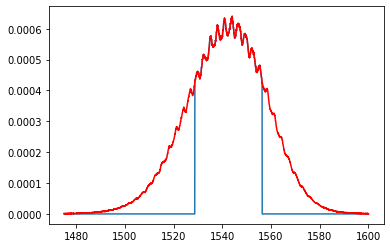

In [37]:
samplePath = os.path.join(datasetPath, r"1stSeries_07.05.21/1.48/W0000.CSV")
df_0 = csv_to_df(samplePath)
df_res = restrictROItozero(df_0)

plt.plot(df_res.Wave_Length, df_res.Amplitude)
plt.plot(df_0.Wave_Length, df_0.Amplitude, color='red')

In [15]:
def getLocalMaxima(dataArray):
  # for local maxima
  return dataArray[argrelextrema(dataArray, np.greater)[0]]

def getLocalMinima(dataArray):
  # for local minima
  return dataArray[argrelextrema(dataArray, np.less)[0]]

def getMean(dataArray):
  return np.mean(dataArray)

def getMedian(dataArray):
  return np.median(dataArray)

def getStd(dataArray):
  return np.std(dataArray)

def getMode(dataArray):
  return mode(dataArray).mode[0]

def getAmount(dataArray):
  return dataArray.size

def getAreaUnderCurve(dataArray):
  return simps(dataArray)

def buildFeatures(df, dataArray):
  localMaxima = getLocalMaxima(dataArray)
  localMinima = getLocalMinima(dataArray)
  features = \
  {"Gmax": df.Amplitude.max(),
   "Gmin": df.Amplitude.min(),
   "Gstd": df.Amplitude.std(),
   "Gmean": df.Amplitude.mean(),
   "GfirstQ": df.Amplitude.quantile(0.75),
   "GsecondQ": df.Amplitude.quantile(0.5),
   "GthirdQ": df.Amplitude.quantile(0.25),
   "LmaxMean": getMean(localMaxima),
   "LmaxMedian": getMedian(localMaxima),
   "LmaxStd": getStd(localMaxima),
   "LmaxMode": getMode(localMaxima),
   "LmaxAmount": getAmount(localMaxima),
   "LminMean": getMean(localMinima),
   "LminMedian": getMedian(localMinima),
   "LminStd": getStd(localMinima),
   "LminMode": getMode(localMinima),
   "LminAmount": getAmount(localMinima),
   "RestrictedRegionArea": getAreaUnderCurve(dataArray),
   "OriginalArea": getAreaUnderCurve(df.Amplitude.to_numpy())
  }
  return features

In [ ]:
def csvToFeaturesDict(csvPath):
  df_0 = pd.read_csv(csvPath, sep=',', header=None, \
                     names=['Wave_Length', 'Amplitude'], skiprows=24)
  df_restricted = restrictROI(df_0)
  df_ampl_numpified = df_restricted.to_numpy()[:, 1]
  dForm = buildFeatures(df_0, df_ampl_numpified)
  return dForm

res_df = pd.DataFrame()

for index, filepath in enumerate(files):
  if filepath.endswith("REF.CSV"):
    continue
  # print(filepath)
  ref_index = float(os.path.basename(os.path.dirname(filepath)))
  ref_cond = ref_index > 1.38
  print(ref_index, ref_cond)
  dictFeatures = csvToFeaturesDict(filepath)
  dictFeatures.update({"isCancer": ref_cond})

  dfFeatures = pd.DataFrame(dictFeatures, index=[index])
  res_df = res_df.append(dfFeatures)

In [28]:
res_df.to_csv("featurizedStuff.csv", index=False)